# Employee Turnover Prediction Dataset Overview

## About the Data

The dataset revolves around the HR department's goal of predicting whether employees would leave the company within the next 2 years. A predictive model is being developed to assess the prospects of both future and present employees.

## Dataset Details

The dataset comprises 8 features and 1 label, with a combination of categorical and numerical attributes:

1. **Education:** Education level of the employee.
2. **JoiningYear:** Year in which the employee joined the company.
3. **City:** City where the employee's office is located.
4. **PaymentTier:** Payment tier categorization (1: Highest, 2: Mid Level, 3: Lowest).
5. **Age:** Current age of the employee.
6. **Gender:** Gender of the employee.
7. **EverBenched:** Whether the employee has ever been kept out of projects for 1 month or more.
8. **ExperienceInCurrentDomain:** The number of years of experience employees have in their current field.

**Label:**
- **LeaveOrNot:** Binary indicator of whether the employee is predicted to leave the company in the next 2 years (1: Leaves, 0: Stays).


## Objective

The primary objective is to develop a predictive model that effectively identifies employees at risk of leaving the company within the next 2 years. The dataset's features provide valuable insights for HR decision-making and employee retention strategies.

## Dataset Source

The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/data).


# 1. Importing Libraries and Datasets

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
df = pd.read_csv("employee.csv")
df.columns = df.columns.str.lower()

df1=df.copy()

# 2. Exploratory Data Analysis (EDA)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")

    print("\n##################### Types #####################")
    print(dataframe.dtypes)

    print("\n##################### Head #####################")
    print(dataframe.head(head))

    print("\n##################### Tail #####################")
    print(dataframe.tail(head))

    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())

    print("\n##################### Quantiles #####################")
    print(dataframe.describe().T)

    
check_df(df)

##################### Shape #####################
Rows: 4653
Columns: 9

##################### Types #####################
education                    object
joiningyear                   int64
city                         object
paymenttier                   int64
age                           int64
gender                       object
everbenched                  object
experienceincurrentdomain     int64
leaveornot                    int64
dtype: object

##################### Head #####################
   education  joiningyear       city  paymenttier  age  gender everbenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   experienceincurre

In [4]:
leaveornot_values = {
    1: 'Leave',
    0: 'Stay'
}

df.leaveornot = df.leaveornot.map(leaveornot_values)

In [5]:
##################################################
# Capturing numerical and Categorical variables 
##################################################

# This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

def grab_col_names(dataframe, cat_th=8, car_th=20):
       """

    Provides the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
            The dataframe from which variable names are to be extracted.
        cat_th: int, optional
            Class threshold value for numerical-looking categorical variables.
        car_th: int, optional
            Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
            List of categorical variable names.
        num_cols: list
            List of numerical variable names.
        cat_but_car: list
            List of categorical-looking cardinal variable names.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        Numerical-looking categorical variables are included in cat_cols.
        The sum of the 3 lists returned is equal to the total number of variables: cat_cols + num_cols + cat_but_car = total number of variables.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations: 4653
Variables: 9
cat_cols: 7
num_cols: 2
cat_but_car: 0
num_but_cat: 2


In [7]:
cat_cols

['education',
 'city',
 'gender',
 'everbenched',
 'leaveornot',
 'joiningyear',
 'paymenttier']

In [8]:
num_cols

['age', 'experienceincurrentdomain']

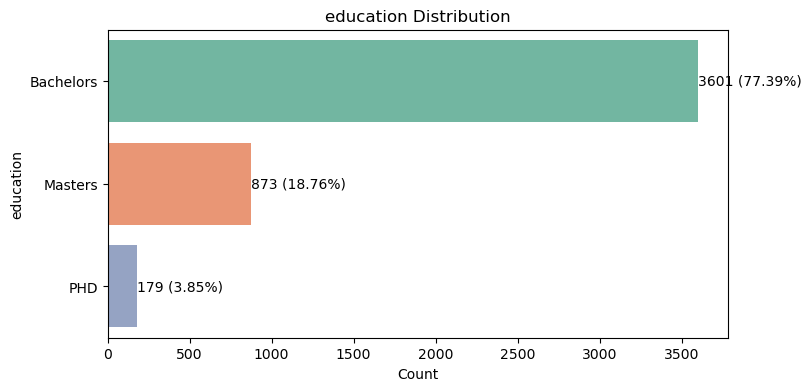

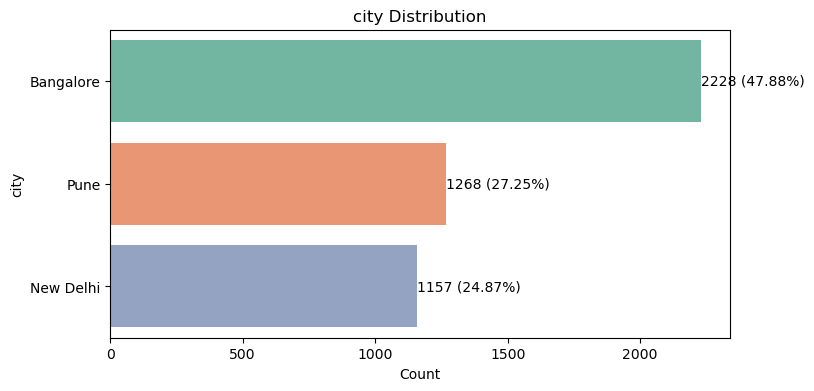

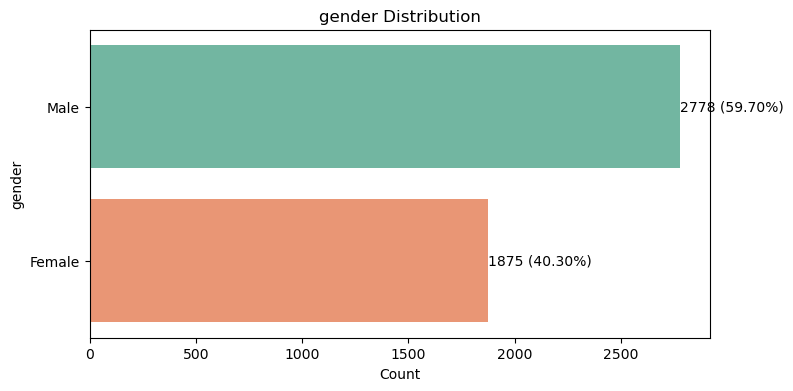

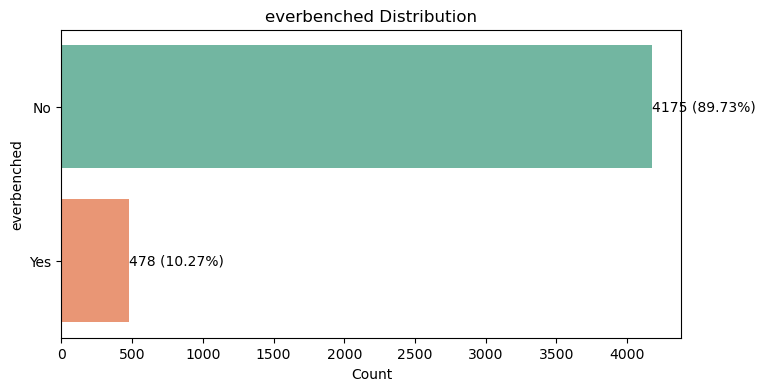

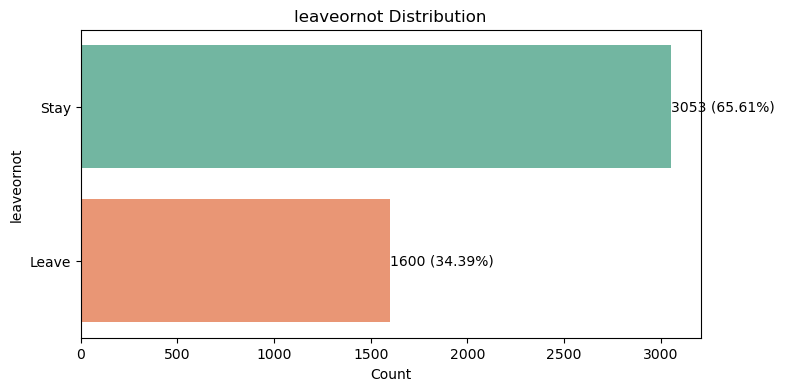

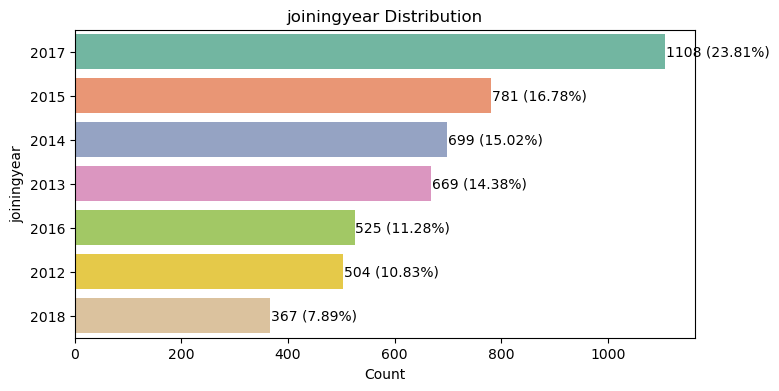

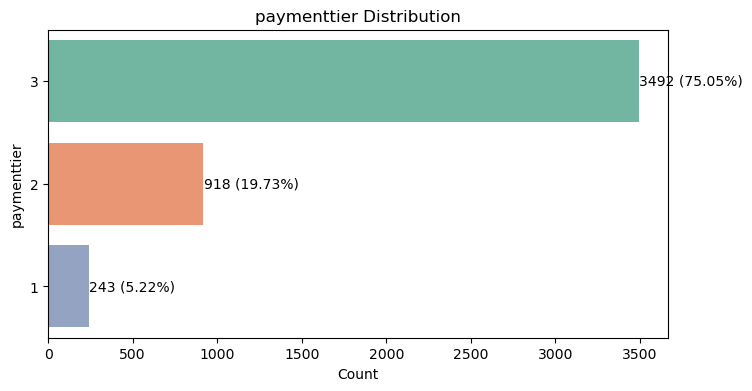

In [9]:
#########################################
# Analysis of Categorical Variables
#########################################

# This function performs the analysis and visualization of categorical variables.

def cat_summary(dataframe, col_name, plot=True):
    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)
    
    if plot:
        plt.figure(figsize=(8, 4))
        
        
        custom_palette = sns.color_palette("Set2", len(value_counts))
        
        sns.countplot(y=dataframe[col_name], data=dataframe, order=value_counts.index, palette=custom_palette)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation=0)
        
        for i, v in enumerate(value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%)", va='center')
        
        plt.show()
        
        
for col in cat_cols:
    cat_summary(df, col, plot=True)

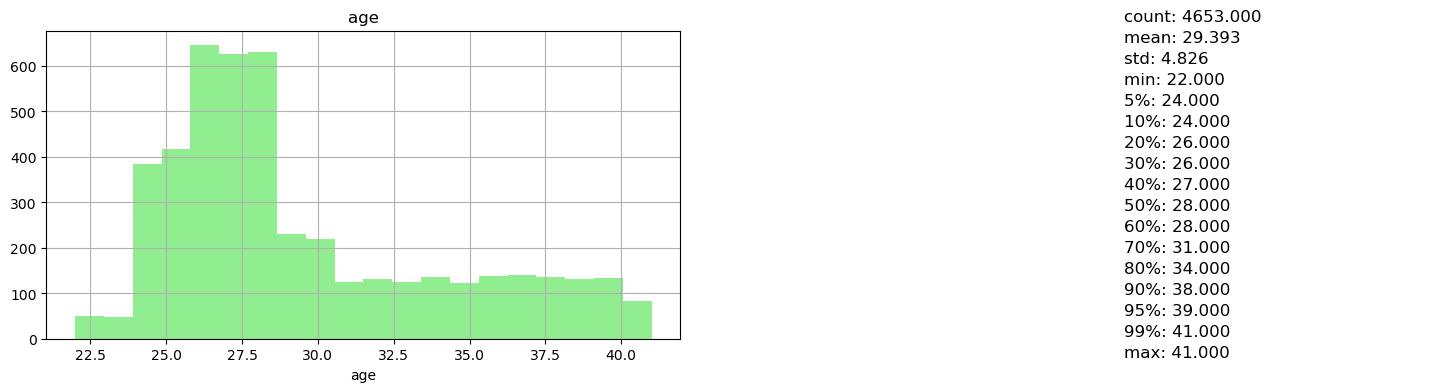

################################################################


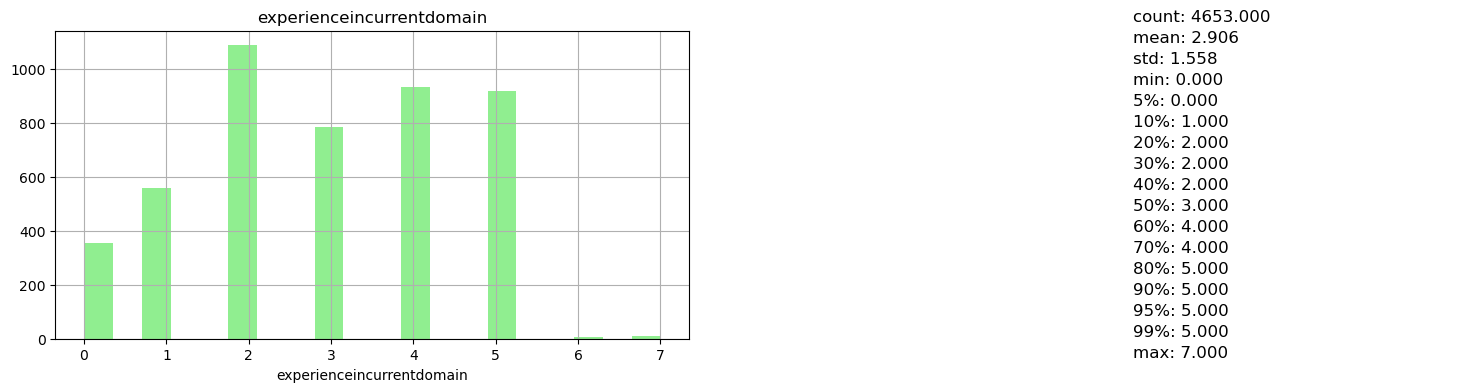

################################################################


In [10]:
########################################
# Analysis of Numerical Variables
########################################

# This function performs the analysis of numerical variables and, if desired, visualizes them.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")
        
        
for col in num_cols:
    num_summary(df, col, plot=True)

In [11]:
########################################
#   Target Variable Analysis    
########################################

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    print("##########################################")

for col in num_cols:
    target_summary_with_num(df, "leaveornot", col)

                  age
leaveornot           
Leave       29.052500
Stay        29.571896


##########################################
            experienceincurrentdomain
leaveornot                           
Leave                        2.840000
Stay                         2.940059


##########################################


In [12]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"leaveornot_count": dataframe.groupby(categorical_col)[target].count()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "leaveornot", col)

           leaveornot_count
education                  
Bachelors              3601
Masters                 873
PHD                     179


           leaveornot_count
city                       
Bangalore              2228
New Delhi              1157
Pune                   1268


        leaveornot_count
gender                  
Female              1875
Male                2778


             leaveornot_count
everbenched                  
No                       4175
Yes                       478


            leaveornot_count
leaveornot                  
Leave                   1600
Stay                    3053


             leaveornot_count
joiningyear                  
2012                      504
2013                      669
2014                      699
2015                      781
2016                      525
2017                     1108
2018                      367


             leaveornot_count
paymenttier                  
1                         243
2           

In [13]:
##################################
# Outlier Analysis
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
  

for col in num_cols:
    print(col, check_outlier(df, col))

age False
experienceincurrentdomain False


# 3. Data Preparation

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = (df_train.leaveornot == 'Leave').astype('int').values
y_val = (df_val.leaveornot == 'Leave').astype('int').values
y_test = (df_test.leaveornot == 'Leave').astype('int').values

In [17]:
del df_train['leaveornot']
del df_val['leaveornot']
del df_test['leaveornot']

# 4. Decision Tree Model

In [18]:
train_dicts = df_train.to_dict(orient='records')

In [19]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7861772633103365

In [23]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9855092934065315

Overfitting?

### 4.1. Decision tree parameter tuning

In [24]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.616
   2 -> 0.734
   3 -> 0.782
   4 -> 0.817
   5 -> 0.838
   6 -> 0.840
  10 -> 0.826
  15 -> 0.794
  20 -> 0.782
None -> 0.788


In [25]:
scores = []

for depth in [4, 5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [26]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [27]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth            4      5      6      10
min_samples_leaf                            
1                 0.817  0.838  0.843  0.828
5                 0.819  0.841  0.850  0.852
10                0.820  0.840  0.847  0.844
15                0.820  0.839  0.852  0.851
20                0.820  0.840  0.853  0.845
100               0.820  0.834  0.839  0.833
200               0.811  0.822  0.826  0.826
500               0.707  0.707  0.707  0.707

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

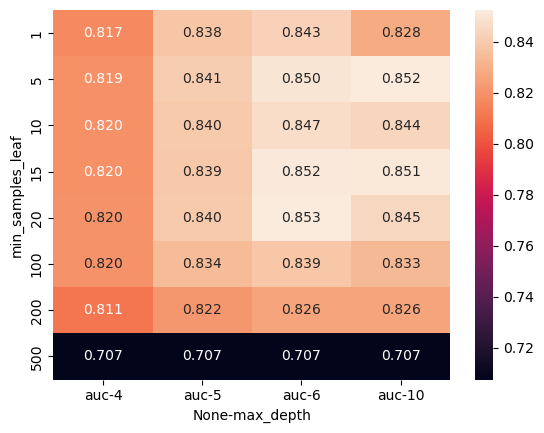

In [28]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [29]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8502147152885332

In [30]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- joiningyear <= 2017.50
|   |--- paymenttier <= 2.50
|   |   |--- joiningyear <= 2016.50
|   |   |   |--- paymenttier <= 1.50
|   |   |   |   |--- city=Pune <= 0.50
|   |   |   |   |   |--- education=Masters <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- education=Masters >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- city=Pune >  0.50
|   |   |   |   |   |--- education=Masters <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- education=Masters >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- paymenttier >  1.50
|   |   |   |   |--- education=Bachelors <= 0.50
|   |   |   |   |   |--- joiningyear <= 2013.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- joiningyear >  2013.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- education=Bachelors >  0.50
|   |   |   |   |   |--- gender=Female <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- gender=Female >  0.

### 4.2. Ensembles and random forest

In [32]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [33]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

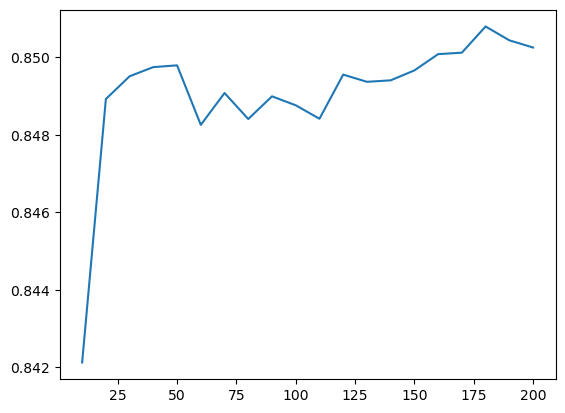

In [34]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [35]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [36]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

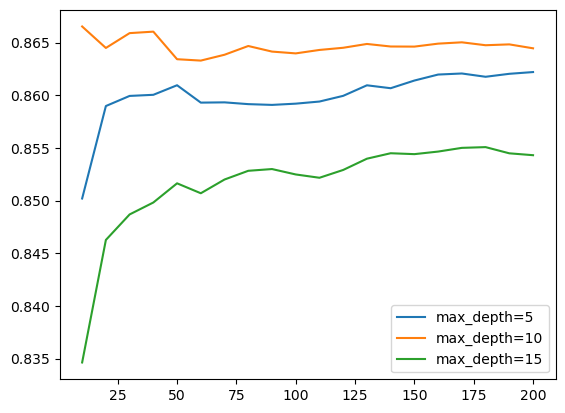

In [37]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

The value of __max_depth=10__ seems to be the best one.

In [38]:
max_depth = 10

In [39]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [40]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

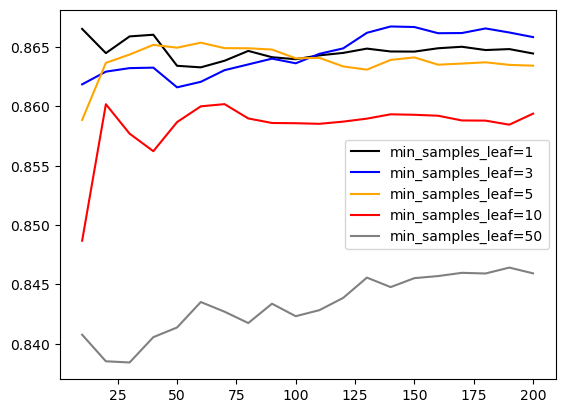

In [41]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

__min_samples_leaf=3__ looks like it's good enough.

In [42]:
min_samples_leaf = 3

In [45]:
rf = RandomForestClassifier(n_estimators=180,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=180,
                       random_state=1)

### 4.3. Gradient boosting and XGBoost

In [46]:
import xgboost as xgb

In [47]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [51]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [52]:
y_pred = model.predict(dval)

In [53]:
roc_auc_score(y_val, y_pred)

0.8642717782649798

In [54]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [55]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [56]:
s = output.stdout

In [57]:
print(s[:200])

[0]	train-auc:0.87433	val-auc:0.84851
[5]	train-auc:0.89109	val-auc:0.86252
[10]	train-auc:0.90347	val-auc:0.86515
[15]	train-auc:0.91440	val-auc:0.86474
[20]	train-auc:0.92037	val-auc:0.86380
[25]	tr


In [58]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [59]:
df_score = parse_xgb_output(output)

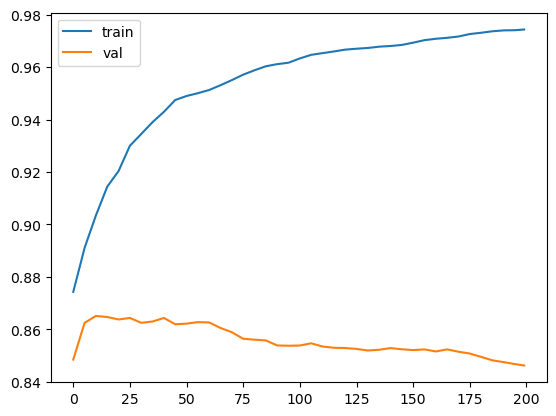

In [60]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

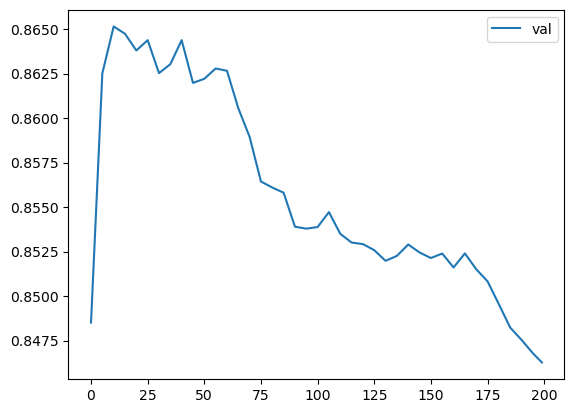

In [61]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### 4.4. XGBoost parameter tuning

In [62]:
scores = {}

In [76]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [77]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [78]:
scores['eta=0.01']

,num_iter,train_auc,val_auc
0,0,0.87433,0.84851
1,5,0.87434,0.84852
2,10,0.87633,0.85346
3,15,0.87636,0.85477
4,20,0.87745,0.85560
5,25,0.87777,0.85608
6,30,0.87766,0.85581
7,35,0.87793,0.85578
8,40,0.87907,0.85731
9,45,0.87837,0.85592


In [80]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

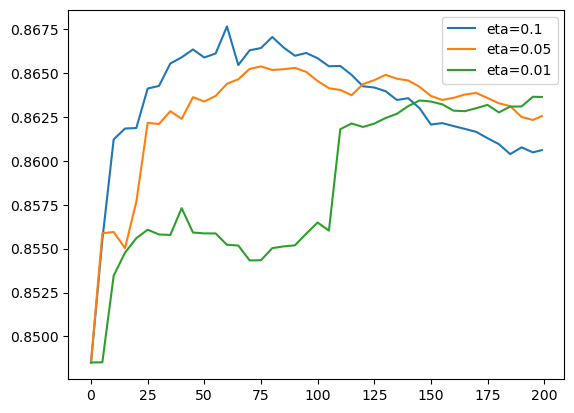

In [87]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()    

From the above graph, `eta=0.1` is the best.

In [88]:
# tuning max_depth

scores = {}

In [95]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [96]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [97]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

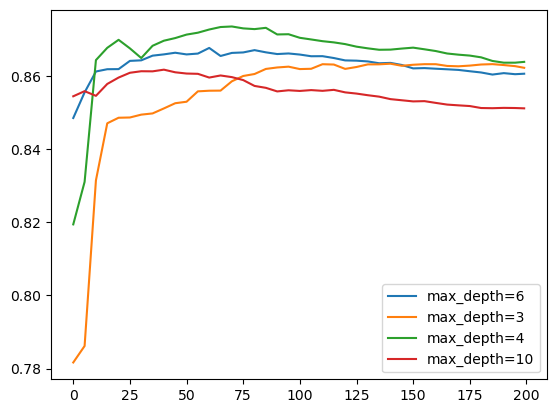

In [98]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

From the above graph, `max_depth=4` is the best.

In [99]:
# tuning min_child_weight

scores = {}

In [104]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [105]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [106]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

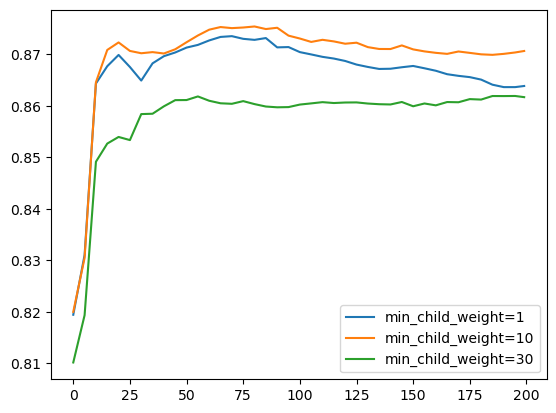

In [107]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()

From the above graph, `min_child_weight=10` is the best.

results: `eta = 0.1`, `max_depth = 4`, `min_child_weight=10`

In [108]:
# final xgb model

xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=70)

### 4.5. Selecting the final model

In [109]:
# decision tree model

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

In [110]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8502147152885332

In [111]:
# randomforest model

rf = RandomForestClassifier(n_estimators=180,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=180,
                       random_state=1)

In [112]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8665748134440936

In [113]:
# xgb model

xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=70)

In [114]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8744820685077538

We see that **XGBoost** is the best model.

In [116]:
df_full_train = df_full_train.reset_index(drop=True)

In [118]:
y_full_train = (df_full_train.leaveornot == 'Leave').astype(int).values

In [119]:
del df_full_train['leaveornot']

In [121]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [124]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [125]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=70)

In [126]:
y_pred = model.predict(dtest)

In [127]:
roc_auc_score(y_test, y_pred)

0.8945520092774668

## Save the model

In [128]:
import pickle

In [129]:
output_file = "model.bin"

In [130]:
with open(output_file, "wb") as f_out:
    pickle.dump((dv, model), f_out)

## Load the model

In [1]:
import pickle
import xgboost as xgb
import numpy as np

In [2]:
model_file = "model.bin"

In [3]:
with open(model_file, "rb") as f_in:
    dv, model = pickle.load(f_in)

In [4]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x245a4d7f40>)

In [28]:
employee1 = {
    'education': 'Masters',
    'joiningyear': 2017,
    'city': 'Bangalore',
    'paymenttier': 3,
    'age': 34,
    'gender': 'Male',
    'everbenched': 'No',
    'experienceincurrentdomain': 0
}

In [29]:
X = dv.transform([employee1])

In [30]:
dx = xgb.DMatrix(X, feature_names=dv.get_feature_names_out().tolist())

In [31]:
prediction = model.predict(dx)
prediction

array([0.5418593], dtype=float32)